(60, 160, 3)


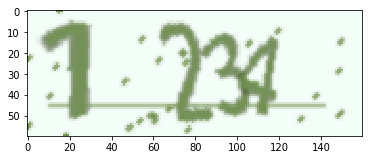

In [3]:
from captcha.image import ImageCaptcha
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

text = '1234'
image = ImageCaptcha()
captcha = image.generate(text)
captcha_image = Image.open(captcha)
#captcha_image.show()
plt.imshow(captcha_image)
print(np.array(captcha_image).shape)

In [2]:
VOCAB = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
CAPTCHA_LENGTH = 4
VOCAB_LENGTH = len(VOCAB)

In [3]:
from captcha.image import ImageCaptcha
import numpy as np

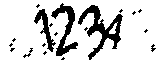

In [4]:
def image_deal(image):
##########   图片转灰度处理   ############
    image = image.convert('L')
#     image = image.resize((28, 28)) # 缩放
    
##########   图片二值化处理   ############
    # 阈值
    threshold = 180
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    # 图片二值化，此处第二个参数为数字一
    image = image.point(table, '1') #table 中含有256个值，分别对应256个像素点的映射值, 0是最黑的， 1是最白的
    
    return image

image_deal(captcha_image)

In [5]:
def generate_captcha(captcha_text):
    '''
    get captcha text
    return np array of captcha image
    '''
    image = ImageCaptcha()
    captcha = image.generate(captcha_text)
    captcha_image = Image.open(captcha)
    captcha_image = image_deal(captcha_image)
    captcha_array = np.array(captcha_image)
    captcha_array = captcha_array[np.newaxis,:,:]
    
    return captcha_array

In [6]:
def text2vec(text):
    '''
    text to vector
    :param text: source text
    :return: np array
    '''
    if len(text) > CAPTCHA_LENGTH:
        return False
    
    vector = np.zeros(CAPTCHA_LENGTH * VOCAB_LENGTH)
    
    for i, c in enumerate(text):
        index = i * VOCAB_LENGTH + VOCAB.index(c)
        vector[index] = 1
    return vector

def vec2text(vector):
    '''
    vector to text
    :param text: source vector
    :return: text'''
    if len(vector) != 40:
        return False
    
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    
    text = ''
    
    for i in range(0,4):
        text += VOCAB[np.argmax(vector[i*10:(i+1)*10])]
    
    return text

In [7]:
import random
from os.path import join, exists
import pickle
import numpy as np
from os import makedirs

DATA_LENGTH = 1000
DATA_PATH = 'data'

def get_random_text():
    text = ''
    for i in range(CAPTCHA_LENGTH):
        text += random.choice(VOCAB)
    return text

In [8]:
def generate_data():
    print('Generating Data...')
    data_x, data_y = [], []

    # generate data x and y
    for i in range(DATA_LENGTH):
        text = get_random_text()
        # get captcha array
        captcha_array = generate_captcha(text)
        # get vector
        vector = text2vec(text)
        data_x.append(captcha_array)
        data_y.append(vector)

    # write data to pickle
    if not exists(DATA_PATH):
        makedirs(DATA_PATH)

    x = np.asarray(data_x, np.float32)
    y = np.asarray(data_y, np.float32)
    with open(join(DATA_PATH, 'data.pkl'), 'wb') as f:
        pickle.dump(x, f)
        pickle.dump(y, f)
        

In [9]:
generate_data()
with open(join(DATA_PATH,'data.pkl'), 'rb') as f:
    data_x = pickle.load(f)
    data_y = pickle.load(f)

Generating Data...


In [10]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.4, random_state=40)
print(train_x.shape)

(600, 1, 60, 160)


/home/lsc/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch

class CaptchaDataset(Dataset):
    def __init__(self, x, y, transform=None):
        super(Dataset, self).__init__()
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, n):
#         self.x[n] = image_deal(self.x[n])
#         self.y[n] = image_deal(self.y[n])
#         self.x[n] = self.x[n][np.newaxis,:,:]
        return self.x[n], self.y[n]

In [12]:
from torchvision import transforms

captcha_train_dataset = CaptchaDataset(train_x, train_y, transform=transforms.ToTensor())
captcha_test_dataset = CaptchaDataset(test_x, test_y, transform=transforms.ToTensor())
train_data = DataLoader(captcha_train_dataset, batch_size=100, shuffle=True)
test_data = DataLoader(captcha_test_dataset, batch_size=100, shuffle=False)
for i, j in train_data:
	break

print(i.shape, i[1], j.shape, j.long())

torch.Size([100, 1, 60, 160]) tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) torch.Size([100, 40]) tensor([[1, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])


In [21]:
###################   leNet   ################
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

class LeNet(nn.Module):
    def __init__(self):
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(LeNet, self).__init__()   # 等价与nn.Module.__init__()

        # nn.Conv2d返回的是一个Conv2d class的一个对象，该类中包含forward函数的实现
        # 当调用self.conv1(input)的时候，就会调用该类的forward函数
        self.conv1 = nn.Conv2d(1, 6, (5, 5))   # output (N, C_{out}, H_{out}, W_{out})`, 图片的维度减少4*4
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        # self.conv3 = nn.Conv2d(16, 16, (5, 5))
        self.fc1 = nn.Linear(7104, 2000)
        self.fc2 = nn.Linear(2000, 840)
        self.fc3 = nn.Linear(840, 40)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) # 
        x = x.view(x.size()[0], -1) #16*56*156=139776
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x



net = LeNet()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for e in range(100):
	for data, label in train_data:
		data = Variable(data)
		label = Variable(label)
		#frontward
		out = net(data)
		loss = criterion(out, label)
		#backward
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()


	########eval#########
	num_correct = 0
	for data, label in test_data:
		data = Variable(data)
		label = Variable(label)
		#frontward
		out = net(data)
		loss = criterion(out, label)

		_, pred = out.max(1)
# 		num_correct += float((pred == label).sum().data)
		
	if e % 5 == 0:
		print("Epoch:", '%04d' % (e+1), "loss=", "%04f" % loss)

Epoch: 0001 loss= 0.698945
Epoch: 0006 loss= 0.695238
Epoch: 0011 loss= 0.693755
Epoch: 0016 loss= 0.693256
Epoch: 0021 loss= 0.693178
Epoch: 0026 loss= 0.693159
Epoch: 0031 loss= 0.693151
Epoch: 0036 loss= 0.693146
Epoch: 0041 loss= 0.693143
Epoch: 0046 loss= 0.693141
Epoch: 0051 loss= 0.693140
Epoch: 0056 loss= 0.693139
Epoch: 0061 loss= 0.693138
Epoch: 0066 loss= 0.693137
Epoch: 0071 loss= 0.693137
Epoch: 0076 loss= 0.693136
Epoch: 0081 loss= 0.693136
Epoch: 0086 loss= 0.693136
Epoch: 0091 loss= 0.693135
Epoch: 0096 loss= 0.693135


(60, 160, 3)


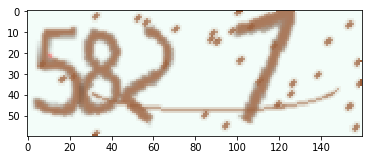

In [22]:
text = '5827'
image = ImageCaptcha()
captcha = image.generate(text)
captcha_image = Image.open(captcha)
#captcha_image.show()
plt.imshow(captcha_image)
print(np.array(captcha_image).shape)

In [24]:
def generate_test_captcha(captcha_text):
    '''
    get captcha text
    return np array of captcha image
    '''
    image = ImageCaptcha()
    captcha = image.generate(captcha_text)
    captcha_image = Image.open(captcha)
    captcha_image = image_deal(captcha_image)
    captcha_array = np.array(captcha_image)
    captcha_array = captcha_array[np.newaxis,:,:]
    
    return captcha_image, captcha_array

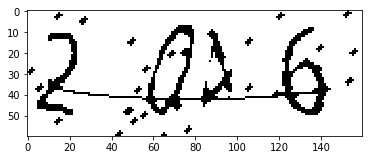

In [54]:
test_text = get_random_text()
test_image, test_array = generate_test_captcha(test_text)
plt.figure()
plt.imshow(test_image)

In [56]:
test_array = test_array.astype(float)
test_variable = Variable(torch.Tensor(test_array))
test_variable.unsqueeze_(0)
out = net(test_variable)
print(type(out), type(out.data.numpy()))
out = out.squeeze_(0).data.numpy()  
test_net = vec2text(out)
out, test_net

<class 'torch.Tensor'> <class 'numpy.ndarray'>


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32), '0000')